# A3: NeuralNetwork Class

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Requirements" data-toc-modified-id="Requirements-1">Requirements</a></span></li><li><span><a href="#Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py" data-toc-modified-id="Code-for-NeuralNetwork-Class-Saved-in-File-neuralnetworkA3.py-2">Code for <code>NeuralNetwork</code> Class Saved in File <code>neuralnetworkA3.py</code></a></span></li><li><span><a href="#Example-Results" data-toc-modified-id="Example-Results-3">Example Results</a></span></li><li><span><a href="#More-Detailed-Example-Use" data-toc-modified-id="More-Detailed-Example-Use-4">More Detailed Example Use</a></span></li><li><span><a href="#Application-to-Seoul-Bike-Sharing-Demand-Data" data-toc-modified-id="Application-to-Seoul-Bike-Sharing-Demand-Data-5">Application to Seoul Bike Sharing Demand Data</a></span></li></ul></div>

## Requirements

In this assignment, you will complete the implementation of the `NeuralNetwork` class, based on your solution to `A2` and [07a Optimizers2](https://www.cs.colostate.edu/~anderson/cs545/notebooks/07a%20Optimizers2.ipynb), using the code included in the next code cell.  Your implementation must meet the requirements described in the doc-strings.

Run the code in [07a Optimizers2](https://www.cs.colostate.edu/~anderson/cs545/notebooks/07%20Optimizers2.ipynb) to create the file `optimizers2.py` for use in this assignment.

Then apply your `NeuralNetwork` class to the problem of predicting the rental of bicycles in Seoul as described below.

## Code for `NeuralNetwork` Class Saved in File `neuralnetworkA3.py`

In [27]:
%%writefile neuralnetworkA3.py

import numpy as np
import optimizers2 as opt


class NeuralNetwork():
    """
    A class that represents a neural network for nonlinear regression.

    Attributes
    ----------
    n_inputs : int
        The number of values in each sample
    n_hiddens_each_layer : list of ints, or empty
        The number of units in each hidden layer.
        Its length specifies the number of hidden layers.
    n_outputs : int
        The number of units in output layer
    all_weights : one-dimensional numpy array
        Contains all weights of the network as a vector
    Ws : list of two-dimensional numpy arrays
        Contains matrices of weights in each layer,
        as views into all_weights
    all_gradients : one-dimensional numpy array
        Contains all gradients of mean square error with
        respect to each weight in the network as a vector
    Grads : list of two-dimensional numpy arrays
        Contains matrices of gradients weights in each layer,
        as views into all_gradients
   error_trace : list of floats
        Mean square error (unstandardized) after each epoch
    n_epochs : int
        Number of epochs trained so far
    X_means : one-dimensional numpy array
        Means of the components, or features, across samples
    X_stds : one-dimensional numpy array
        Standard deviations of the components, or features, across samples
    T_means : one-dimensional numpy array
        Means of the components of the targets, across samples
    T_stds : one-dimensional numpy array
        Standard deviations of the components of the targets, across samples
        
        
    Methods
    -------
    _make_weights_and_views(shapes)
        Creates all initial weights and views for each layer

    train(Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs, method='sgd', 
          learning_rate=None, momentum=0, weight_penalty=0, verbose=True)
        Trains the network using input and target samples by rows in Xtrain and Ttrain

    use(X)
        Applies network to inputs X and returns network's output
    """

    def __init__(self, n_inputs, n_hidden_each_layer, n_outputs):
        """Creates a neural network with the given structure

        Parameters
        ----------
        n_inputs : int
            The number of values in each sample
        n_hiddens_each_layer : list of ints, or empty
            The number of units in each hidden layer.
            Its length specifies the number of hidden layers.
        n_outputs : int
            The number of units in output layer

        Returns
        -------
        NeuralNetwork object
        """

        self.n_inputs = n_inputs
        self.n_hiddens_each_layer = n_hidden_each_layer
        self.n_outputs = n_outputs

        # Create list of shapes of weight matrices for each layer
        shapes = []
        ni = self.n_inputs
        for nu in self.n_hiddens_each_layer:
            shapes.append((1+ni, nu))
            ni = nu
            
        #for output layer
        shapes.append((1+ni, self.n_outputs))

        # ...

        # Build one-dimensional vector of all weights and weight matrices
        # for each layer as views into this vector.
        # Call _make_weights_and_views to create all_weights and Ws       
        self.all_weights, self.Ws = self._make_weights_and_views(shapes)

        # Call _make_weights_and_views to create all_gradients and Grads
        self.all_gradients, self.Grads = self._make_weights_and_views(shapes)

        
        self.X_means = None
        self.X_stds = None
        self.T_means = None
        self.T_stds = None

        self.n_epochs = 0
        self.error_trace = []


    def _make_weights_and_views(self, shapes):
        """Creates vector of all weights and views for each layer

        Parameters
        ----------
        shapes : list of pairs of ints
            Each pair is number of rows and columns of weights in each layer.
            Number of rows is number of inputs to layer (including constant 1).
            Number of columns is number of units, or outputs, in layer.

        Returns
        -------
        Vector of all weights, and list of views into this vector for each layer
        """

        # Create one-dimensional numpy array of all weights with random initial values between -1 and 1.
        n_weights = np.sum([np.prod(Wshape) for Wshape in shapes])
        all_weights = np.random.uniform(-1, 1, n_weights)
        

        #  ...

        # Build weight matrices as list of views (pairs of number of rows and number 
        # of columns) by reshaping corresponding elements from vector of all weights 
        # into correct shape for each layer and dividing values of each weight matrix 
        # by the square root of number of its inputs. Remember to use /=

        Ws = []
        first_index = 0
        for Wshape in shapes:
            last_index = first_index + np.prod(Wshape)
            nin = Wshape[0]
            W = all_weights[first_index:last_index].reshape(Wshape)
            W /= np.sqrt(nin)
            Ws.append(W)
            first_index = last_index
        
        # ...
        
        # Set output layer weights to zero.
        Ws[-1][:] = np.zeros_like(Ws[-1])
        
        # ...
        return all_weights, Ws
        

    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_each_layer}, {self.n_outputs})'
     
    def __str__(self):
        if self.n_epochs is not None:
            return f'{self.__repr__()} trained for {self.n_epochs} epochs with a final RMSE of {self.rmse}.'   
        else:
            return f'{self.__repr__()} has not been trained.'
 
 
    def train(self, Xtrain, Ttrain, Xvalidate, Tvalidate, n_epochs,
              method='sgd', learning_rate=None, momentum=0, weight_penalty=0, verbose=True):
        """Updates the weights.

        Parameters
        ----------
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        n_epochs : int
            Number of passes to take through all samples
        method : str
            'sgd', 'adam', or 'scg'
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float
            Controls amount of previous weight update to add to current weight update, only for sgd
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        verbose: boolean
            If True, progress is shown with print statements
        """

        # Calculate and assign standardization parameters
        self.X_means = Xtrain.mean(axis=0)
        self.X_stds = Xtrain.std(axis=0)
        self.T_means = Ttrain.mean(axis=0)
        self.T_stds = Ttrain.std(axis=0)
        
        # ...

        # Standardize Xtrain, Ttrain, Xvalidate and Tvalidate.
        XtrainS = (Xtrain - self.X_means) / self.X_stds
        TtrainS = (Ttrain - self.T_means) / self.T_stds
        XvalidateS = (Xvalidate - self.X_means) / self.X_stds
        TvalidateS = (Tvalidate - self.T_means) / self.T_stds
        # ...

        # Instantiate Optimizers object by giving it vector of all weights
        
        optimizer = opt.Optimizers(self.all_weights)

        # Define function to convert mean-square error to root-mean-square error,
        # Here we use a lambda function just to illustrate its use.  
        # We could have also defined this function with
        # def error_convert_f(err):
        #     return np.sqrt(err)
        error_convert_f = lambda err: np.sqrt(err)
        
        # Call the requested optimizer method to train the weights.

        if method == 'sgd':

            self.error_trace = optimizer.sgd(XtrainS, TtrainS, XvalidateS, TvalidateS,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs, learning_rate=learning_rate,
                                             momentum=momentum, weight_penalty=weight_penalty,
                                             verbose=True)


        elif method == 'adamw':

            self.error_trace = optimizer.adamw(XtrainS, TtrainS, XvalidateS, TvalidateS,
                                               self.error_f, self.gradient_f,
                                               n_epochs=n_epochs, learning_rate=learning_rate,
                                               weight_penalty=weight_penalty,
                                               verbose=True)

        elif method == 'scg':

            self.error_trace = optimizer.scg(XtrainS, TtrainS, XvalidateS, TvalidateS,
                                             self.error_f, self.gradient_f,
                                             n_epochs=n_epochs, 
                                             weight_penalty=weight_penalty,
                                             verbose=True)

        else:
            raise Exception("method must be 'sgd', 'adam', or 'scg'")

        self.n_epochs += len(self.error_trace)
        self.best_epoch = optimizer.best_epoch

        # Return neural network object to allow applying other methods
        # after training, such as:    Y = nnet.train(X, T, 100, 0.01).use(X)

        return self

    def _add_ones(self, X):
        return np.insert(X, 0, 1, 1)
    
    def _forward(self, X):
        """Calculate outputs of each layer given inputs in X.
        
        Parameters
        ----------
        X : input samples, standardized.

        Returns
        -------
        Standardized outputs of all layers as list, include X as first element.
        """
        
        self.Zs = [X]
        
        # Append output of each layer to list in self.Zs, then return it.
        
        for i in range(len(self.Ws) -1):
            z = np.tanh(self._add_ones(self.Zs[i]) @ self.Ws[i])
            self.Zs.append(z)

        # Y doesn't need tanh activation
        Y = self._add_ones(self.Zs[-1]) @ self.Ws[-1]
        self.Zs.append(Y)
        return self.Zs
        # ...

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        """Calculate output of net given input X and its mean squared error.
        Function to be minimized by optimizer.

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  by  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  by  number of output components

        Returns
        -------
        Standardized mean square error as scalar float that is the mean
        square error over all samples and all network outputs.
        """
        # Call _forward, calculate mean square error and return it.
        Y = self._forward(X)[-1]
        
        return np.mean((T-Y)**2)
        # ...

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        """Returns gradient wrt all weights. Assumes _forward already called
        so input and all layer outputs stored in self.Zs

        Parameters
        ----------
        X : two-dimensional numpy array, standardized
            number of samples  x  number of input components
        T : two-dimensional numpy array, standardized
            number of samples  x  number of output components

        Returns
        -------
        Vector of gradients of mean square error wrt all weights
        """

        # Assumes forward_pass just called with layer outputs saved in self.Zs.
        
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        n_layers = len(self.n_hiddens_each_layer) + 1

        # delta is delta matrix to be back propagated.
        # Dividing by n_samples and n_outputs here replaces the scaling of
        # the learning rate.
        
        delta = -(T - self.Zs[-1]) / (n_samples * n_outputs)

        # Step backwards through the layers to back-propagate the error (delta)
        
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            Z = self.Zs[layeri]
            self.Grads[layeri][:] = self._add_ones(Z).T @ delta
           # Back-propagate this layer's delta to previous layer
            if layeri > 0:
                delta = (delta @ self.Ws[layeri][1:, :].T) * (1 - Z**2)

        return self.all_gradients

    def use(self, X):
        """Return the output of the network for input samples as rows in X.
        X assumed to not be standardized.

        Parameters
        ----------
        X : two-dimensional numpy array
            number of samples  by  number of input components, unstandardized

        Returns
        -------
        Output of neural network, unstandardized, as numpy array
        of shape  number of samples  by  number of outputs
        """

        # Standardize X
        X_S = (X - self.X_means) / self.X_stds
        # ...

        # Call _forward to get the neural network's output
        Y_S = self._forward(X_S)[-1]
        # ...
        
        # Unstandardize output Y before returning it
        Y = Y_S * self.T_stds + self.T_means
        return Y

    def get_error_trace(self):
        """Returns list of root-mean square error for each epoch"""
        return self.error_trace

Overwriting neuralnetworkA3.py


## Example Results

Here we test the `NeuralNetwork` class with some simple data.  


In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import neuralnetworkA3 as nn  # Your file produced from the above code cell.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)

nnet = nn.NeuralNetwork(X.shape[1], [2, 2], 1)
    
# Set all weights here to allow comparison of your calculations
# Must use [:] to overwrite values in all_weights.
# Without [:], new array is assigned to self.all_weights, so self.Ws no longer refer to same memory
nnet.all_weights[:] = np.arange(len(nnet.all_weights)) * 0.001

nnet.train(X, T, X, T, n_epochs=1, method='sgd', learning_rate=0.1)

nnet.Ws


SGD: Epoch 1 MSE=1.00010,1.00010


[array([[-1.51603124e-07,  9.99801782e-04],
        [ 2.00719909e-03,  3.00940664e-03]]),
 array([[0.00398889, 0.00498788],
        [0.00600106, 0.00700115],
        [0.00800157, 0.00900172]]),
 array([[0.00898958],
        [0.01099768],
        [0.01199691]])]

In [30]:
X, T

(array([[0. ],
        [0.5],
        [1. ],
        [1.5]]),
 array([[ 0.        ],
        [-0.45973279],
        [-0.45777798],
        [ 0.64865886]]))

In [31]:
[w.shape for w in nnet.Ws]

[(2, 2), (3, 2), (3, 1)]

In [32]:
nnet.Zs

[array([[-1.34164079],
        [-0.4472136 ],
        [ 0.4472136 ],
        [ 1.34164079]]),
 array([[-0.00268328, -0.00302491],
        [-0.00089443, -0.00034164],
        [ 0.00089443,  0.00234164],
        [ 0.00268328,  0.00502488]]),
 array([[0.00395968, 0.00495395],
        [0.00399188, 0.00499062],
        [0.00402408, 0.00502729],
        [0.00405628, 0.00506396]]),
 array([[0.010103  ],
        [0.0101038 ],
        [0.01010459],
        [0.01010539]])]

In [41]:
nnet.Grads

[array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]])]

In [42]:
Y = nnet.use(X)
Y

array([[-0.06308723],
       [-0.06308687],
       [-0.06308651],
       [-0.06308615]])

In [18]:
X, T

(array([[0. ],
        [0.5],
        [1. ],
        [1.5]]),
 array([[ 0.        ],
        [-0.45973279],
        [-0.45777798],
        [ 0.64865886]]))

## More Detailed Example Use

In [33]:
Xtrain = np.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = np.sin(Xtrain) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 

In [34]:
errors = []
Ytests = []
n_epochs = 4000
method_rhos = [('sgd', 0.05),
               ('adamw', 0.005),
               ('scg', None)] 

SGD: Epoch 400 MSE=0.86112,1.04674
SGD: Epoch 800 MSE=0.12453,0.65324
SGD: Epoch 1200 MSE=0.02682,0.80611
SGD: Epoch 1600 MSE=0.01866,0.85893
SGD: Epoch 2000 MSE=0.01532,0.84453
SGD: Epoch 2400 MSE=0.00993,0.81765
SGD: Epoch 2800 MSE=0.00357,0.80814
SGD: Epoch 3200 MSE=0.00136,0.81262
SGD: Epoch 3600 MSE=0.00075,0.81978
SGD: Epoch 4000 MSE=0.00055,0.82424
AdamW: Epoch 400 MSE=0.16781,0.80081
AdamW: Epoch 800 MSE=0.14684,0.80467
AdamW: Epoch 1200 MSE=0.14641,0.81160
AdamW: Epoch 1600 MSE=0.14617,0.82065
AdamW: Epoch 2000 MSE=0.14599,0.82218
AdamW: Epoch 2400 MSE=0.14581,0.82834
AdamW: Epoch 2800 MSE=0.00096,0.65220
AdamW: Epoch 3200 MSE=0.00032,0.68225
AdamW: Epoch 3600 MSE=0.00021,0.68879
AdamW: Epoch 4000 MSE=0.00015,0.68943
SCG: Epoch 400 MSE=0.00037,0.78660
SCG: Epoch 800 MSE=0.00003,0.74556
SCG: Epoch 1200 MSE=0.00001,0.74071
SCG: Epoch 1600 MSE=0.00000,0.74184
SCG: Epoch 2000 MSE=0.00000,0.74423
SCG: Epoch 2400 MSE=0.00000,0.74731
SCG: Epoch 2800 MSE=0.00000,0.74812
SCG: Epoch 320

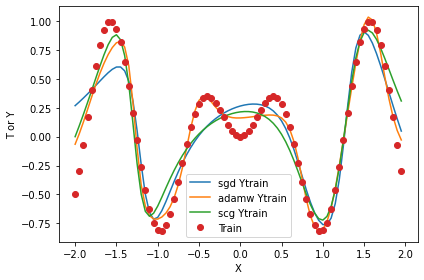

In [35]:
for method, rho in method_rhos:
    nnet = nn.NeuralNetwork(Xtrain.shape[1], [10, 10], 1)
    nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs, method=method, learning_rate=rho,
               momentum=0.9)  # momentum only affects sgd)
    Ytrain = nnet.use(Xtrain)
    plt.plot(Xtrain, Ytrain, '-', label=method + ' Ytrain')
    errors.append(nnet.get_error_trace())
    Ytests.append(nnet.use(Xtest))

plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.xlabel('X')
plt.ylabel('T or Y')
plt.legend()
plt.tight_layout()

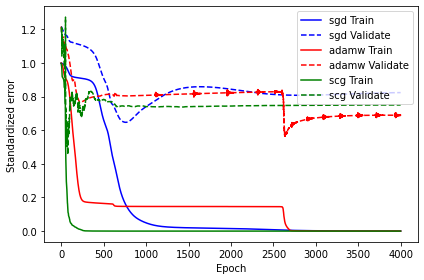

In [36]:
errors = np.stack(errors)
# errors is now 3 x n_epochs x 2
colors = ['b', 'r', 'g']
styles = ['-', '--']
for methodi, method in enumerate([mr[0] for mr in method_rhos]):
    for train_val_i, train_val in enumerate(['Train', 'Validate']):
        plt.plot(errors[methodi, :, train_val_i], f'{colors[methodi]}{styles[train_val_i]}',
                 label=f'{method} {train_val}')
plt.xlabel('Epoch')
plt.ylabel('Standardized error')
plt.legend()
plt.tight_layout()

In [37]:
def plot_Y_vs_T(Y, T, title):
    plt.plot(T, Y, 'o', alpha=0.6)
    a = min(min(T), min(Y))[0]
    b = max(max(T), max(Y))[0]
    plt.axline((a, a), (b, b), linewidth=4, color='r', alpha=0.5)
    plt.xlabel('T')
    plt.ylabel('Y')
    plt.title(title)

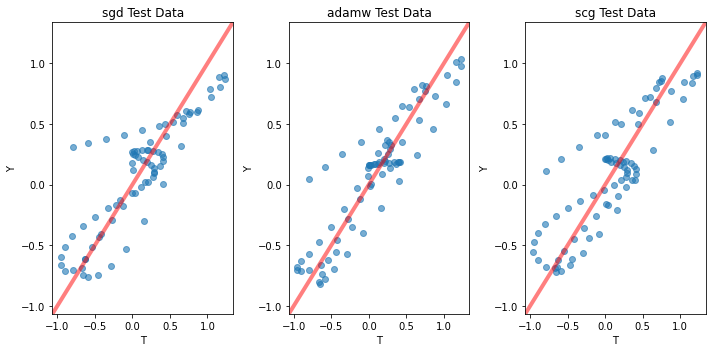

In [38]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_Y_vs_T(Ytests[i], Ttest, f'{method_rhos[i][0]} Test Data')
plt.tight_layout()

## Application to Seoul Bike Sharing Demand Data

Download data from [bike-sharing.csv](https://www.cs.colostate.edu/~anderson/cs545/notebooks/bike-sharing.csv).  This is data modified very slightly from [UC Irvine ML Repo](https://archive-beta.ics.uci.edu/ml/datasets/seoul+bike+sharing+demand#Abstract). Read it into python using the `pandas.read_csv` function.  Assign `X` and `T` as shown.

In [2]:
import pandas

data = pandas.read_csv('bike-sharing.csv')
T = data['Rented Bike Count'].to_numpy().reshape(-1, 1)
X = data[['Hour', 'Temperature(C)', 'Humidity(%)',
          'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
          'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']].to_numpy()
X.shape, T.shape

C:\Users\diloc\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


((8760, 9), (8760, 1))

Before training your neural networks, partition the data into training, validation and testing partitions, as shown here.

In [3]:
import numpy as np
def partition(X, T, train_validation_test_fractions):

    if np.sum(train_validation_test_fractions) != 1:
        raise Exception(f'The three components of train_validation_test_fractions must sum to 1.\n Your value was {train_validation_test_fractions}')
        
    train_fraction, val_fraction, test_fraction = train_validation_test_fractions

    n_samples = X.shape[0]
    rows = np.arange(n_samples)
    np.random.shuffle(rows)

    n_train = round(n_samples * train_fraction)
    n_val = round(n_samples * val_fraction)
    n_test = n_samples - n_train - n_val

    Xtrain = X[rows[:n_train], :]
    Ttrain = T[rows[:n_train], :]

    Xval = X[rows[n_train:n_train + n_val], :]
    Tval = T[rows[n_train:n_train + n_val], :]

    Xtest = X[rows[-n_test:], :]
    Ttest = T[rows[-n_test:], :]

    return Xtrain, Ttrain, Xval, Tval, Xtest, Ttest

def rmse(T, Y):
    return np.sqrt(np.mean((T - Y)**2))

In [4]:
# Assuming you have assigned `X` and `T` correctly.

Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, (0.8, 0.1, 0.1))


Xtrain.shape, Ttrain.shape, Xval.shape, Tval.shape, Xtest.shape, Ttest.shape

((7008, 9), (7008, 1), (876, 9), (876, 1), (876, 9), (876, 1))

Write and run code using your `NeuralNetwork` class to model the Seoul bike sharing data. Experiment with all three optimization methods and a variety of neural network structures (numbers of hidden layer and units), learning rates, and numbers of epochs. Show results for at least three different network structures, learning rates, and numbers of epochs for each method.  Set `weight_penalty` to 0 for all, and set `momentum` to 0.9 for sgd. Show your results in a pandas DataFrame with columns `('Method', 'Structure', 'Epochs', 'Learning Rate', 'Train RMSE', 'Test RMSE')`, where `Train RMSE` and `Test RMSE` are unstandardized errors. 

Use the `pandas` functions `sort_values` and `head` to show the top 20 best results, with "best" being the lowest `Test RMSE`.

Try to find good values for the RMSE on testing data.  Discuss your results, including how good you think the RMSE values are by considering the range of bike sharing counts given in the data. 

In [7]:
epochs = [1000, 5000, 10000]
learning_rates = [0.0005, 0.01, 0.05]

structures = [[10],[10,5],[30,20,10]]

methods = ['sgd', 'adamw', 'scg']

result = []

def calc_rmse(T, Y):
        return np.sqrt(np.mean((T - Y) ** 2))

for method in methods:
    for structure in structures:
      for learning_rate in learning_rates:
        for n_epochs in epochs:
          nnet = nn.NeuralNetwork(Xtrain.shape[1], structure, T.shape[1])
          Ytrain = nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs=n_epochs, method=method, learning_rate=learning_rate,momentum=0.9).use(Xtrain)
          rmse_train = calc_rmse(Ttrain, nnet.use(Xtrain))
          rmse_test = calc_rmse(Ttest, nnet.use(Xtest))
          result.append([method, structure,learning_rate,n_epochs, rmse_train, rmse_test])

SGD: Epoch 100 MSE=0.90569,1.00999
SGD: Epoch 200 MSE=0.82358,0.92329
SGD: Epoch 300 MSE=0.75083,0.84405
SGD: Epoch 400 MSE=0.68985,0.77577
SGD: Epoch 500 MSE=0.64427,0.72351
SGD: Epoch 600 MSE=0.61264,0.68674
SGD: Epoch 700 MSE=0.59056,0.66117
SGD: Epoch 800 MSE=0.57426,0.64264
SGD: Epoch 900 MSE=0.56163,0.62856
SGD: Epoch 1000 MSE=0.55159,0.61750
SGD: Epoch 500 MSE=0.65750,0.74228
SGD: Epoch 1000 MSE=0.52300,0.58666
SGD: Epoch 1500 MSE=0.51120,0.57256
SGD: Epoch 2000 MSE=0.50533,0.56631
SGD: Epoch 2500 MSE=0.50020,0.56090
SGD: Epoch 3000 MSE=0.49513,0.55556
SGD: Epoch 3500 MSE=0.49007,0.55020
SGD: Epoch 4000 MSE=0.48512,0.54489
SGD: Epoch 4500 MSE=0.48035,0.53971
SGD: Epoch 5000 MSE=0.47578,0.53470
SGD: Epoch 1000 MSE=0.51076,0.57325
SGD: Epoch 2000 MSE=0.49503,0.55438
SGD: Epoch 3000 MSE=0.48538,0.54402
SGD: Epoch 4000 MSE=0.47658,0.53460
SGD: Epoch 5000 MSE=0.46809,0.52541
SGD: Epoch 6000 MSE=0.45990,0.51644
SGD: Epoch 7000 MSE=0.45214,0.50787
SGD: Epoch 8000 MSE=0.44497,0.49992
SG

SGD: Epoch 1000 MSE=0.36777,0.41568
SGD: Epoch 2000 MSE=0.32664,0.37405
SGD: Epoch 3000 MSE=0.29513,0.35049
SGD: Epoch 4000 MSE=0.26021,0.31695
SGD: Epoch 5000 MSE=0.24605,0.30706
SGD: Epoch 6000 MSE=0.23714,0.29862
SGD: Epoch 7000 MSE=0.23167,0.29197
SGD: Epoch 8000 MSE=0.22789,0.28732
SGD: Epoch 9000 MSE=0.22484,0.28420
SGD: Epoch 10000 MSE=0.22204,0.28205
SGD: Epoch 100 MSE=0.42373,0.47585
SGD: Epoch 200 MSE=0.38396,0.43158
SGD: Epoch 300 MSE=0.36034,0.40593
SGD: Epoch 400 MSE=0.33859,0.38487
SGD: Epoch 500 MSE=0.32185,0.37072
SGD: Epoch 600 MSE=0.30394,0.35634
SGD: Epoch 700 MSE=0.28830,0.34442
SGD: Epoch 800 MSE=0.27596,0.33176
SGD: Epoch 900 MSE=0.26535,0.31950
SGD: Epoch 1000 MSE=0.25806,0.31211
SGD: Epoch 500 MSE=0.30992,0.36223
SGD: Epoch 1000 MSE=0.25727,0.31352
SGD: Epoch 1500 MSE=0.23114,0.29170
SGD: Epoch 2000 MSE=0.21966,0.28006
SGD: Epoch 2500 MSE=0.21176,0.27520
SGD: Epoch 3000 MSE=0.20451,0.27179
SGD: Epoch 3500 MSE=0.19899,0.26858
SGD: Epoch 4000 MSE=0.19436,0.26676
S

AdamW: Epoch 100 MSE=0.60005,0.67914
AdamW: Epoch 200 MSE=0.49261,0.55309
AdamW: Epoch 300 MSE=0.46900,0.52399
AdamW: Epoch 400 MSE=0.42670,0.47881
AdamW: Epoch 500 MSE=0.39581,0.44422
AdamW: Epoch 600 MSE=0.37695,0.42265
AdamW: Epoch 700 MSE=0.36243,0.40505
AdamW: Epoch 800 MSE=0.35034,0.39131
AdamW: Epoch 900 MSE=0.33943,0.38092
AdamW: Epoch 1000 MSE=0.32820,0.37227
AdamW: Epoch 500 MSE=0.39081,0.43852
AdamW: Epoch 1000 MSE=0.31763,0.36358
AdamW: Epoch 1500 MSE=0.26528,0.31780
AdamW: Epoch 2000 MSE=0.22483,0.27890
AdamW: Epoch 2500 MSE=0.20504,0.27049
AdamW: Epoch 3000 MSE=0.18923,0.27331
AdamW: Epoch 3500 MSE=0.17704,0.27982
AdamW: Epoch 4000 MSE=0.16578,0.29247
AdamW: Epoch 4500 MSE=0.15569,0.30911
AdamW: Epoch 5000 MSE=0.14751,0.32904
AdamW: Epoch 1000 MSE=0.31933,0.36318
AdamW: Epoch 2000 MSE=0.22298,0.28529
AdamW: Epoch 3000 MSE=0.18576,0.28047
AdamW: Epoch 4000 MSE=0.15820,0.30214
AdamW: Epoch 5000 MSE=0.13704,0.32454
AdamW: Epoch 6000 MSE=0.12159,0.34607
AdamW: Epoch 7000 MSE=

SCG: Epoch 3000 MSE=0.22415,0.28489
SCG: Epoch 3500 MSE=0.22352,0.28437
SCG: Epoch 4000 MSE=0.22275,0.28435
SCG: Epoch 4500 MSE=0.22212,0.28683
SCG: Epoch 5000 MSE=0.22188,0.28670
SCG: Epoch 1000 MSE=0.22049,0.27483
SCG: Epoch 2000 MSE=0.21612,0.27599
SCG: Epoch 3000 MSE=0.21437,0.27887
SCG: Epoch 4000 MSE=0.21349,0.28174
SCG: Epoch 5000 MSE=0.21280,0.28444
SCG: Epoch 6000 MSE=0.21223,0.28663
SCG: Epoch 7000 MSE=0.21177,0.28722
SCG: Epoch 8000 MSE=0.21134,0.28577
SCG: Epoch 9000 MSE=0.21120,0.28563
SCG: Epoch 10000 MSE=0.21105,0.28565
SCG: Epoch 100 MSE=0.30437,0.35257
SCG: Epoch 200 MSE=0.26959,0.31055
SCG: Epoch 300 MSE=0.25587,0.30432
SCG: Epoch 400 MSE=0.24591,0.30025
SCG: Epoch 500 MSE=0.24114,0.29298
SCG: Epoch 600 MSE=0.23853,0.28574
SCG: Epoch 700 MSE=0.23629,0.28048
SCG: Epoch 800 MSE=0.23269,0.27522
SCG: Epoch 900 MSE=0.23038,0.27777
SCG: Epoch 1000 MSE=0.22757,0.27869
SCG: Epoch 500 MSE=0.23001,0.28870
SCG: Epoch 1000 MSE=0.22187,0.28725
SCG: Epoch 1500 MSE=0.21899,0.28767
S

In [9]:
len(result)

81

In [10]:
df = pandas.DataFrame(result)

# Optionally, you can set column names if needed
column_names = ['Method','Structure','Learning Rate', 'Epochs', 'Train RMSE', 'Test RMSE']
df.columns = column_names
df

,Method,Structure,Learning Rate,Epochs,Train RMSE,Test RMSE
0,sgd,[10],0.0005,1000,473.872029,508.276992
1,sgd,[10],0.0005,5000,440.135885,478.746168
2,sgd,[10],0.0005,10000,419.902588,454.414416
3,sgd,[10],0.0100,1000,411.065755,436.124351
4,sgd,[10],0.0100,5000,371.342687,391.623773
...,...,...,...,...,...,...
76,scg,"[30, 20, 10]",0.0100,5000,288.788436,325.436799
77,scg,"[30, 20, 10]",0.0100,10000,288.910131,326.799041
78,scg,"[30, 20, 10]",0.0500,1000,283.310072,323.083934
79,scg,"[30, 20, 10]",0.0500,5000,291.504935,335.060427


In [14]:
df.sort_values(by=['Test RMSE'], ascending=[True]).head(20)

,Method,Structure,Learning Rate,Epochs,Train RMSE,Test RMSE
72,scg,"[30, 20, 10]",0.0005,1000,263.005134,320.126411
50,adamw,"[30, 20, 10]",0.0100,10000,283.619337,322.004310
25,sgd,"[30, 20, 10]",0.0500,5000,279.162914,322.008395
78,scg,"[30, 20, 10]",0.0500,1000,283.310072,323.083934
47,adamw,"[30, 20, 10]",0.0005,10000,284.551873,323.874827
76,scg,"[30, 20, 10]",0.0100,5000,288.788436,325.436799
64,scg,"[10, 5]",0.0005,5000,297.927942,326.147969
65,scg,"[10, 5]",0.0005,10000,292.152845,326.443039
77,scg,"[30, 20, 10]",0.0100,10000,288.910131,326.799041
48,adamw,"[30, 20, 10]",0.0100,1000,274.288729,326.847293


Discussion:


From the above dataframe, it can be observed that we obtain the lowest Test RMSE for a neural network with three hidden layers using SCG method. It was obtained with a learning rate of 0.0005 with 1000 epochs. Considering the range of bike sharing count(the target value) being 3556, this seems like a decent rmse for using the trained model. However, it can be seen that the difference between train rmse and test rmse is too huge in this instance. Hence, I don't think this is a good enough model to predict bike sharing count due to overfitting over the training data.

The peformance of model seems to improve with lower RMSE values as we increase the number of hidden layers and units in each layer. The results for model with 3 hidden layers shows that it fits relatively quick compared to one with 2 hidden layers. It can also be seen that increasing the learning rate doesn't provide significant improvement relative to initial values. It seems like even though higher learning rate provides faster results, it might not be the optimal solution for the trained neural network.

All of the top 6 models with three hidden layers seem to overfit giving a wider difference between training and test rmse. As we go lower in the dataframe, it can be seen that models with two layers seem to have a lower difference between training and test rmse, and not much difference from the least rmse as well. This shows that adding more complexity to the network with additional hidden layers doesn't ensure better performance. To my understanding the model with two hidden layers using SCG method is performing well on testing data and gives good RMSE values. However, a much thorough experimentation would be needed before being used in the real world.

# Grading

<font color="red">Available soon!</font>.

Your notebook will be run and graded automatically. Test this grading process by first downloading [A3grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A3grader.tar) and extract `A3grader.py` from it. Run the code in the following cell to demonstrate an example grading session. As always, a different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'A3solution.ipynb' and then save this notebook. Check in your notebook in Canvas.

In [39]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'A3solution.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing

    def check_weight_views(nnet):
        results = []
        for layeri, W in enumerate(nnet.Ws):
            if np.shares_memory(nnet.all_weights, W):
                print(f'nnet.Ws[{layeri}] correctly shares memory with nnet.all_weights')
                results.append(True)
            else:
                print(f'nnet.Ws[{layeri}] does not correctly share memory with nnet.all_weights')
                results.append(False)

        return np.all(results)

    import neuralnetworkA3 as nn

    n_inputs = 3
    n_hiddens = [5, 10, 20]
    n_outputs = 2

    nnet = nn.NeuralNetwork(n_inputs, n_hiddens, n_outputs)

    weight_views_correct = check_weight_views(nnet)

nnet.Ws[0] correctly shares memory with nnet.all_weights
nnet.Ws[1] co

AdamW: Epoch 600 MSE=0.04329,0.04329
AdamW: Epoch 800 MSE=0.01557,0.01557
AdamW: Epoch 1000 MSE=0.00350,0.00350
AdamW: Epoch 1200 MSE=0.00120,0.00120
AdamW: Epoch 1400 MSE=0.00068,0.00068
AdamW: Epoch 1600 MSE=0.00049,0.00049
AdamW: Epoch 1800 MSE=0.00040,0.00040
AdamW: Epoch 2000 MSE=0.00036,0.00036
Net 13 RMSE 0.01478
AdamW: Epoch 200 MSE=0.29420,0.29420
AdamW: Epoch 400 MSE=0.08508,0.08508
AdamW: Epoch 600 MSE=0.02465,0.02465
AdamW: Epoch 800 MSE=0.00619,0.00619
AdamW: Epoch 1000 MSE=0.00197,0.00197
AdamW: Epoch 1200 MSE=0.00085,0.00085
AdamW: Epoch 1400 MSE=0.00053,0.00053
AdamW: Epoch 1600 MSE=0.00042,0.00042
AdamW: Epoch 1800 MSE=0.00037,0.00037
AdamW: Epoch 2000 MSE=0.00035,0.00035
Net 14 RMSE 0.01455
AdamW: Epoch 200 MSE=0.28473,0.28473
AdamW: Epoch 400 MSE=0.08902,0.08902
AdamW: Epoch 600 MSE=0.04309,0.04309
AdamW: Epoch 800 MSE=0.02067,0.02067
AdamW: Epoch 1000 MSE=0.00593,0.00593
AdamW: Epoch 1200 MSE=0.00168,0.00168
AdamW: Epoch 1400 MSE=0.00075,0.00075
AdamW: Epoch 1600 MS

SGD: Epoch 300 MSE=0.02069,0.22347
SGD: Epoch 600 MSE=0.00650,0.19428
SGD: Epoch 900 MSE=0.00254,0.19104
SGD: Epoch 1200 MSE=0.00092,0.19218
SGD: Epoch 1500 MSE=0.00032,0.19437
SGD: Epoch 1800 MSE=0.00012,0.19629
SGD: Epoch 2100 MSE=0.00006,0.19763
SGD: Epoch 2400 MSE=0.00004,0.19850
SGD: Epoch 2700 MSE=0.00003,0.19905
SGD: Epoch 3000 MSE=0.00003,0.19939
Net 12 RMSE 0.03838 best epoch 917
SGD: Epoch 300 MSE=0.01955,0.17547
SGD: Epoch 600 MSE=0.00764,0.15785
SGD: Epoch 900 MSE=0.00372,0.16193
SGD: Epoch 1200 MSE=0.00179,0.16907
SGD: Epoch 1500 MSE=0.00085,0.17559
SGD: Epoch 1800 MSE=0.00040,0.18049
SGD: Epoch 2100 MSE=0.00020,0.18382
SGD: Epoch 2400 MSE=0.00012,0.18599
SGD: Epoch 2700 MSE=0.00008,0.18735
SGD: Epoch 3000 MSE=0.00006,0.18821
Net 13 RMSE 0.06597 best epoch 602
SGD: Epoch 300 MSE=0.01786,0.23585
SGD: Epoch 600 MSE=0.00306,0.19712
SGD: Epoch 900 MSE=0.00079,0.19297
SGD: Epoch 1200 MSE=0.00023,0.19310
SGD: Epoch 1500 MSE=0.00009,0.19384
SGD: Epoch 1800 MSE=0.00005,0.19451
SGD

# Extra Credit

Using a network that gives you pretty good test RMSE results, try to figure out which input features are most significant in predicting the bike-share count.  Remember, that our neural networks is trained with standardized inputs, so you can compare the magnitudes of weights in the first layer to help you determine which inputs are most significant. 

To visualize the weights, try displaying the weights in the first layer as an image, with `plt.imshow` with `plt.colorbar()`. Discuss which weights have the largest magnitudes and discuss any patterns in see in the weights in each hidden unit of the first layer.

SCG: Epoch 500 MSE=0.23460,0.28220
SCG: Epoch 1000 MSE=0.22875,0.27881
SCG: Epoch 1500 MSE=0.22696,0.27995
SCG: Epoch 2000 MSE=0.22587,0.27981
SCG: Epoch 2500 MSE=0.22492,0.27923
SCG: Epoch 3000 MSE=0.22422,0.28003
SCG: Epoch 3500 MSE=0.22379,0.28086
SCG: Epoch 4000 MSE=0.22319,0.28052
SCG: Epoch 4500 MSE=0.22282,0.28168
SCG: Epoch 5000 MSE=0.22233,0.28256


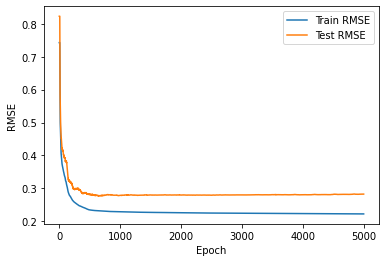

In [17]:
# using SCG
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,5], T.shape[1])
Ytrain = nnet.train(Xtrain, Ttrain, Xval, Tval, n_epochs=5000, method='scg', learning_rate=0.0005,momentum=0.9).use(Xtrain)
fig = plt.figure()
plt.clf()
plt.plot(nnet.get_error_trace())
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(('Train RMSE', 'Test RMSE'))

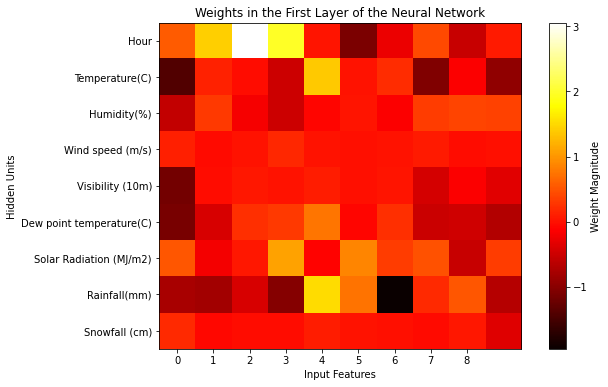

In [23]:

# Assuming `model` is your trained neural network model
weights_array = nnet.Ws[0][1:, :]  # Exclude bias weights

# Visualize weights as an image
plt.figure(figsize=(10, 6))
plt.imshow(weights_array, cmap='hot', interpolation='nearest')
plt.colorbar(label='Weight Magnitude')
plt.xlabel('Input Features')
plt.ylabel('Hidden Units')
plt.title('Weights in the First Layer of the Neural Network')

feature_labels = ['Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 
                  'Visibility (10m)', 'Dew point temperature(C)', 
                  'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

plt.yticks(np.arange(len(feature_labels)), feature_labels, rotation='horizontal')
plt.xticks(np.arange(len(weights_array)))


plt.show()


For the above heatmap, I have set the colormap to red for lower values and to yellowish for higher values. It can be seen in the heatmap that there are yellow and orange spots in certain units of the first hidden layer for Rainfall, Solar Radiation and Hour. This signifies that bike riding count is positively correlated to these parameters in particular. However, there might be other parameters too that can be correlated which can explored with much thorough experimentation.